#### GBM image post-processing
##### using a copy of UO_edit_fov_visualization_cluster_spatial_singlecell.ipynb
##### 1st May 2023
##### 2nd May ; plots as subplots (red dots), create typing class, 
##### 3rd May : updated both the typing classes, generated one set of figures for 1st image
##### 8th May : cleaned the plots
##### 19th May: Re-arraged cells, re-coded amp_code and cell_type_code, changed color scheme, added mutation_status_code group, edited size of dots
##### 21st May: y-axis inversion of plots to match image coordinates.
##### 10th June: loop across all images
##### 11th June: single-view clustering and compacting
##### 12th June: Github upload
##### 13th June: single cell resolution code, arrange file names
##### 15th June: combine data, plotting, Github
##### 20th Sep: count matrix rebuild for reflectance mapping
##### 26th Oct/10th Oct/9th Nov/14th Nov: spatial data build/MV clustering
##### 15th Nov/16th Nov:MV clustering/within pri and recu

In [284]:
### added phenograph install
!pip install PhenoGraph 
import numpy as np
import pandas as pd
import scipy.integrate
import math
import matplotlib.pyplot as plt
import seaborn as sns
import phenograph
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
import time
import multiprocessing as mp
import os

from scipy.stats import zscore

#from sklearn.manifold import TSNE
#from sklearn.mixture import BayesianGaussianMixture
from openTSNE import TSNE



import phenograph as pg
import random

from matplotlib.lines import Line2D

from mvlearn.cluster import MultiviewCoRegSpectralClustering
from sklearn.metrics.pairwise import euclidean_distances


[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import matplotlib.colors as mcolors

mcolors.BASE_COLORS #these colors can be called with a single character

mcolors.TABLEAU_COLORS #the default color cycle colors

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

In [6]:
'''
find . | grep .git | xargs rm -rf
find . -name ".DS_Store" -delete
'''

'\nfind . | grep .git | xargs rm -rf\nfind . -name ".DS_Store" -delete\n'

In [7]:
colours_30 = ["gainsboro", "crimson","gold", "dodgerblue","darkorange","darkviolet","seagreen","lightpink"]
colours_31 = ["whitesmoke","silver", "orange","chocolate", "yellowgreen","forestgreen","darkkhaki","darkolivegreen",
            "pink","hotpink"]
colours_32 = ["gainsboro", "maroon"]
colours_33 = ["cadetblue","saddlebrown","slategrey","powderblue",
            "palevioletred","mediumvioletred","yellowgreen","lemonchiffon","chocolate",
              "lightsalmon","lightcyan","lightblue", "darkorange","magenta","sienna","midnightblue","tomato","tomato","aqua",
             "darkslategray","coral","lightcoral","sandybrown","indianred","olivedrab","darkgreen","blueviolet","forestgreen","darkred",
             "dimgray","teal","mistyrose"]
colours_41 = ["cadetblue","saddlebrown","slategrey","powderblue",
            "palevioletred","mediumvioletred","yellowgreen","lemonchiffon","chocolate",
              "lightsalmon","lightcyan","lightblue", "darkorange","magenta","sienna","midnightblue","tomato","tomato","aqua",
             "darkslategray","coral","lightcoral","sandybrown","indianred","olivedrab","darkgreen","blueviolet","forestgreen","darkred",
             "dimgray","teal","mistyrose","cadetblue","saddlebrown","slategrey","powderblue",
            "palevioletred","mediumvioletred","yellowgreen","lemonchiffon","chocolate",
              "lightsalmon","lightcyan","lightblue", "darkorange","magenta","sienna","midnightblue","tomato","tomato","aqua",
             "darkslategray","coral","lightcoral","sandybrown","indianred","olivedrab","darkgreen","blueviolet","forestgreen","darkred",
             "dimgray","teal","mistyrose"]

In [8]:
##necessary paths
data_path = '/Users/4470526/Downloads/Projects/GBM_SCRIPPS/ImageAnalysis_Moffitt_Complete/'
loc='all_count_matrices/'
data_path_output = '/Users/4470526/Downloads/Projects/GBM_SCRIPPS/ImageAnalysis_Moffitt_Complete/output/sc2/'


In [9]:
gn_list = []
pn_list = []
mn_list = []

In [10]:
#data_path = 'C:\\Users\\ugoma\\Dropbox (Scripps Research)\\Janiszewska Lab\\Ugoma_JaniszewskaLab\\Projects\\ImageAnalysis_Moffitt_Complete\\'
#name = 'CM_Case05RecuA2_Broad'
#count_matrix =  np.array(pd.read_csv(os.path.join(data_path+name+'.csv'), header=0,index_col=None)) 

In [11]:
### Genotyping classification: Changed to specifically categorize, single, double and triple amplifiation including equivocal. 
### Removed Equivocal class
### Ordered heirarchacally to avoid overlap with elif looping

amp_code = -1
def genotyping(r1):
    ##genotype wt and mut combined
          
    if (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,5] <6) 
        and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7) and (count_matrix[r1,6] ==0))) :
        amp_code = 0 #no amp C228T wt
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,5] <6) 
        and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7) and (count_matrix[r1,6] >=1))) :
        amp_code = 0 #no amp C228T mut     
    
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and (count_matrix[r1,6] ==0)) :
        amp_code = 1 #pdgfra amp C228T wt    
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and (count_matrix[r1,6] >=1)) :
        amp_code = 1 #pdgfra amp C228T mut
              
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,9] <7) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] ==0)):
        amp_code = 2 #egfr amp C228T wt
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,9] <7) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] >=1)):
        amp_code = 2 #egfr amp C228T mut       
   
    elif (((count_matrix[r1,4] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] ==0)):
        amp_code = 3 #cdk4 amp C228T wt  
    elif (((count_matrix[r1,4] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] >=1)):
        amp_code = 3 #cdk4 amp C228T mut
        
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,9] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] ==0)):
        amp_code = 4 #egfr + pdgfra amp C228T wt
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,9] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] >=1)):
        amp_code = 4 #egfr + pdgfra amp C228T mut
        
    
    elif (((count_matrix[r1,4] <6) and (count_matrix[r1,10] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] ==0)):
        amp_code = 5 #cdk4 + pdgfra amp C228T wt
    elif (((count_matrix[r1,4] <6) and (count_matrix[r1,10] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] >=1)):
        amp_code = 5 #cdk4 + pdgfra amp C228T mut

    elif (((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] ==0)):
        amp_code = 6 #cdk4 + egfr amp C228T wt
    elif (((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] >=1)):
        amp_code = 6 #cdk4 + egfr amp C228T mut

    elif (((count_matrix[r1,3] >=6) or (count_matrix[r1,9] >=7)) and 
          ((count_matrix[r1,4] >=6) or (count_matrix[r1,10] >=7)) and 
          ((count_matrix[r1,5] >=6) or (count_matrix[r1,11] >=7)) and (count_matrix[r1,6] ==0)) :
        amp_code = 7 #all amp C228T wt      
    elif (((count_matrix[r1,3] >=6) or (count_matrix[r1,9] >=7)) and 
          ((count_matrix[r1,4] >=6) or (count_matrix[r1,10] >=7)) and 
          ((count_matrix[r1,5] >=6) or (count_matrix[r1,11] >=7)and (count_matrix[r1,6] >=1))) :
        amp_code = 7 #all amp C228T mut
        
    return(amp_code)

geno_labels=['No amp','PDGFRA amp','EGFR amp','CDK4 amp','PDGFRA + EGFR amp','CDK4 + PDGFRA amp',
             'CDK4 + EGFR amp','CDK4 + EGFR + PDGFRA amp']

In [12]:
'''
### Function to identify amplified cells WITH mutations

amp_code2 = -4
def genotyping2(r1):
    ##genotype mut
          
    if (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,5] <6) 
        and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7) and (count_matrix[r1,6] >=1))) :
        amp_code2 = 0 #no amp C228T mut
      
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and (count_matrix[r1,6] >=1)) :
        amp_code2 = 1 #pdgfra amp C228T mut  
                 
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,9] <7) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] >=1)):
        amp_code2 = 2 #egfr amp C228T mut
   
   
    elif (((count_matrix[r1,4] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] >=1)):
        amp_code2 = 3 #cdk4 amp C228T mut  
         
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,9] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] >=1)):
        amp_code2 = 4 #egfr + pdgfra amp C228T mut
     
    elif (((count_matrix[r1,4] <6) and (count_matrix[r1,10] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] >=1)):
        amp_code2 = 5 #cdk4 + pdgfra amp C228T mut

    elif (((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] >=1)):
        amp_code2 = 6 #cdk4 + egfr amp C228T mut

    elif (((count_matrix[r1,3] >=6) or (count_matrix[r1,9] >=7)) and 
          ((count_matrix[r1,4] >=6) or (count_matrix[r1,10] >=7)) and 
          ((count_matrix[r1,5] >=6) or (count_matrix[r1,11] >=7)and (count_matrix[r1,6] >=1))) :
        amp_code2 = 7 #all amp C228T mut
    
    return(amp_code2)

geno2_labels=['No amp','PDGFRA amp','EGFR amp','CDK4 amp','PDGFRA + EGFR amp','CDK4 + PDGFRA amp',
             'CDK4 + EGFR amp','CDK4 + EGFR + PDGFRA amp']'''

"\n### Function to identify amplified cells WITH mutations\n\namp_code2 = -4\ndef genotyping2(r1):\n    ##genotype mut\n          \n    if (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,5] <6) \n        and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7) and (count_matrix[r1,6] >=1))) :\n        amp_code2 = 0 #no amp C228T mut\n      \n    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7)) and \n          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and (count_matrix[r1,6] >=1)) :\n        amp_code2 = 1 #pdgfra amp C228T mut  \n                 \n    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,9] <7) and (count_matrix[r1,11] <7)) and \n          not((count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] >=1)):\n        amp_code2 = 2 #egfr amp C228T mut\n   \n   \n    elif (((count_matrix

In [13]:
'''
### function to identify amplified cells WITHOUT TERT C228T mutations


amp_code2 = -4
def genotyping2(r1):
    ##genotype wt
          
    if (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,5] <6) 
        and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7) and (count_matrix[r1,6] ==0))) :
        amp_code2 = 0 #no amp C228T wt
          
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and (count_matrix[r1,6] ==0)) :
        amp_code2 = 1 #pdgfra amp C228T wt    
              
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,9] <7) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] ==0)):
        amp_code2 = 2 #egfr amp C228T wt
   
    elif (((count_matrix[r1,4] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] ==0)):
        amp_code2 = 3 #cdk4 amp C228T wt 
            
    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,9] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] ==0)):
        amp_code2 = 4 #egfr + pdgfra amp C228T wt
        
    elif (((count_matrix[r1,4] <6) and (count_matrix[r1,10] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] ==0)):
        amp_code2 = 5 #cdk4 + pdgfra amp C228T wt

    elif (((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and 
          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7) and (count_matrix[r1,3] < 6) and (count_matrix[r1,9] <7)) and (count_matrix[r1,6] ==0)):
        amp_code2 = 6 #cdk4 + egfr amp C228T wt
 
    elif (((count_matrix[r1,3] >=6) or (count_matrix[r1,9] >=7)) and 
          ((count_matrix[r1,4] >=6) or (count_matrix[r1,10] >=7)) and 
          ((count_matrix[r1,5] >=6) or (count_matrix[r1,11] >=7)) and (count_matrix[r1,6] ==0)) :
        amp_code2 = 7 #all amp wt
        
    return(amp_code2)

geno2_labels=['No amp','PDGFRA amp','EGFR amp','CDK4 amp','PDGFRA + EGFR amp','CDK4 + PDGFRA amp',
             'CDK4 + EGFR amp','CDK4 + EGFR + PDGFRA amp']'''


"\n### function to identify amplified cells WITHOUT TERT C228T mutations\n\n\namp_code2 = -4\ndef genotyping2(r1):\n    ##genotype wt\n          \n    if (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,5] <6) \n        and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7) and (count_matrix[r1,11] <7) and (count_matrix[r1,6] ==0))) :\n        amp_code2 = 0 #no amp C228T wt\n          \n    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,4] <6) and (count_matrix[r1,9] <7) and (count_matrix[r1,10] <7)) and \n          not((count_matrix[r1,5] <6) and (count_matrix[r1,11] <7)) and (count_matrix[r1,6] ==0)) :\n        amp_code2 = 1 #pdgfra amp C228T wt    \n              \n    elif (((count_matrix[r1,3] <6) and (count_matrix[r1,5] < 6) and (count_matrix[r1,9] <7) and (count_matrix[r1,11] <7)) and \n          not((count_matrix[r1,4] < 6) and (count_matrix[r1,10] <7)) and (count_matrix[r1,6] ==0)):\n        amp_code2 = 2 #egfr amp C228T wt\n   \n    elif (((co

In [14]:
### function to identify different cell types in the microenvironment
# phenotyping

cell_type_code = -2
def phenotyping(r1, amp_code):
    ##Unclassified TME
    if ((amp_code ==0) and (count_matrix[r1,6]==0) and
        (count_matrix[r1,12]==0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]==0)):
        cell_type_code = 0 # unclassified TME cell
    elif (amp_code ==0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]==0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]>0)):
        cell_type_code = 1 # unclassified TME cell, hypoxic
    
    ##Immune Cell Definitions      
    elif (amp_code ==0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]==0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]==0)):
        cell_type_code = 2 # immune cell
    elif (amp_code ==0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]>0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]==0)):
        cell_type_code = 2 # immune cell
    elif (amp_code ==0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]==0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]>0)):
        cell_type_code = 3 # hypoxic immune cell
    elif (amp_code ==0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]>0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]>0)):
        cell_type_code = 3 # hypoxic immune cell
    
    ##Endothelial Cell Definitions
    elif (amp_code ==0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]>0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]==0)):
        cell_type_code = 4 # endothelial cell
    elif (amp_code ==0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]>0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]>0)):
        cell_type_code = 5 # hypoxic endothelial cell
    
    ##Tumor Cell Definitions
    elif ( (count_matrix[r1,6]>0) and (count_matrix[r1,12]>0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]==0)):
        cell_type_code = 6 # TERT mutant GBM cell, EC mimicry
    elif (amp_code >0 and (count_matrix[r1,6]==0) and (count_matrix[r1,12]>0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]==0)):
        cell_type_code = 6 # GBM cell, C228T wt, EC mimicry
    elif ( (count_matrix[r1,6]>0) and (count_matrix[r1,12]>0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]>0)):
        cell_type_code = 7 # Hypoxic TERT mutant GBM cell, EC mimicry
    elif (amp_code >0 and (count_matrix[r1,6]==0) and (count_matrix[r1,12]>0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]>0)):
        cell_type_code = 7 # Hypoxic GBM cell, C228T wt, EC mimicry
    
    elif ( (count_matrix[r1,6]>0) and (count_matrix[r1,12]==0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]==0)):
        cell_type_code = 8 # GBM cell, TERT mutant
    elif (amp_code >0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]==0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]==0)):
        cell_type_code = 8 # GBM cell, C228T wt
    elif ( (count_matrix[r1,6]>0) and (count_matrix[r1,12]==0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]>0)):
        cell_type_code = 9 # Hypoxic GBM cell,TERT mutant 
    elif (amp_code >0 and (count_matrix[r1,6]==0) and 
          (count_matrix[r1,12]==0) and (count_matrix[r1,13]==0) and (count_matrix[r1,14]>0)):
        cell_type_code = 9 # Hypoxic GBM cell, C228T wt    

    ## previously NA label re-catagorized based on dominating phenotype 
    elif ( (count_matrix[r1,6]>0) and (count_matrix[r1,12]>0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]==0)):
        cell_type_code = 6 # NA (GBM cell, TERT mutant, EC mimicry)
    elif ( (count_matrix[r1,6]>0) and (count_matrix[r1,12]>0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]>0)):
        cell_type_code = 7 # NA (Hypoxic GBM cell, TERT mutant, EC mimicry)
    elif (amp_code >0 and (count_matrix[r1,6]==0) and (count_matrix[r1,12]==0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]==0)):
        cell_type_code = 8 # NA (GBM cell, C228T wt)
    elif ( (count_matrix[r1,6]>0) and (count_matrix[r1,12]==0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]==0)):
        cell_type_code = 8 # NA (GBM cell, TERT mutant)    
    elif (amp_code >0 and (count_matrix[r1,6]==0) and (count_matrix[r1,12]>0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]==0)):
        cell_type_code = 8 # NA (GBM cell, C228T wt)
    elif (amp_code >0 and (count_matrix[r1,6]==0) and (count_matrix[r1,12]>0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]>0)):
        cell_type_code = 9 # NA (Hypoxic GBM cell, C228T wt)   
    elif (amp_code >0 and (count_matrix[r1,6]==0) and (count_matrix[r1,12]==0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]>0)):
        cell_type_code = 9 # NA (Hypoxic GBM cell, C228T wt)
    elif ( (count_matrix[r1,6]>0) and (count_matrix[r1,12]==0) and (count_matrix[r1,13]>0) and (count_matrix[r1,14]>0)):
        cell_type_code = 9 # NA (Hypoxic GBM cell,TERT mutant)

    return(cell_type_code)


pheno_labels = ['Unclassified TME','Hypoxic Unclassified TME','Immune','Hypoxic Immune','Endothelial','Hypoxic Endothelial',
                  'EC Mimicry Tumor Cell','Hypoxic EC Mimicry Tumor Cell', 'Tumor Cell',
                  'Hypoxic Tumor Cell']

In [15]:
### function to differentiate TERT mutation positive from TERT mutation negative cells
# mutation status
mutation_status_code = -3
def mutation(r1):
    if ((count_matrix[r1,6]>0)):
        mutation_status_code = 1 # TERT mutant GBM cell
      
    else:
        mutation_status_code = 0 # C228T wt, GBM
      
    return(mutation_status_code)
mut_labels = ['TERT C228T wt','TERT C228T mut']
    

In [88]:


colors = colours_30[0:9]
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = geno_labels

colors_p = colours_31[0:18]
lines_p = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors_p]
labels_p = pheno_labels

colors_m = colours_32[0:9]
lines_m = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors_m]
labels_m = mut_labels

In [89]:
sorted(os.listdir(data_path+loc))

['CM_Case01PrimA1_Broad.csv',
 'CM_Case01RecuB1_Broad.csv',
 'CM_Case02PrimB3_Broad.csv',
 'CM_Case02RecuA1_Broad.csv',
 'CM_Case03PrimB2_Broad.csv',
 'CM_Case03RecuA1_Broad.csv',
 'CM_Case04PrimB1_Broad.csv',
 'CM_Case04RecuB2_Broad.csv',
 'CM_Case05PrimB3_Broad.csv',
 'CM_Case05RecuA2_Broad.csv',
 'CM_Case06PrimA1_Broad.csv',
 'CM_Case06RecuB1_Broad.csv',
 'CM_Case07PrimA5_Broad.csv',
 'CM_Case07RecuA1_Broad.csv',
 'CM_Case08PrimB2_Broad.csv',
 'CM_Case08RecuC1_Broad.csv',
 'CM_Case09PrimA1_Broad.csv',
 'CM_Case09RecuA4_Broad.csv']

In [ ]:
### code to loop over each count matrix

count = 0
fname_list = [] #list of file names in the order they are read
image_id_list = [] #integer mapping of file names 
num_cells = 0

geno_data_all = np.zeros((1,8))
pheno_data_all = np.zeros((1,10))
muta_data_all = np.zeros((1,2))

count_matrix_overall = []

data_CM = np.zeros((1,37)) 

distance_neigh_CM = np.zeros((1,20)) 
num_neigh = 5 ### change this, if needed


response_list = []
pat_list = []

response_id_list = []
pat_id_list = []

for fname in sorted(os.listdir(data_path+loc)):  

    print('reading file '+ str(count))
    print(fname)
    fname_list.append(fname)
    
    ## to capture response and patient info from file name
    # recurrent = 1, primary = 0
    
    s1=fname.split('_')[1].split('Case')[1]
    print(s1)

    
    if (s1.find('Recu')>0):
        response_list.append(1)
        s2=s1.split('Recu')[0]
        
    elif (s1.find('Prim')>0):
        response_list.append(0)
        s2=s1.split('Prim')[0]
    
    pat_list.append(s2)
    
    ###
    
    count_matrix =  np.array(pd.read_csv(os.path.join(data_path + loc+fname), header=0,index_col=None)) 
    cm = pd.read_csv(os.path.join(data_path + loc+fname), header=0,index_col=None)
    
    print (count_matrix.shape)
    
    ## replace nan with 0
    count_matrix[np.isnan(count_matrix)] = 0
    
    geno_data = np.zeros([count_matrix.shape[0],8])
    pheno_data = np.zeros([count_matrix.shape[0],10])
    muta_data = np.zeros([count_matrix.shape[0],2])
    
    resp_data = np.zeros([count_matrix.shape[0],1])+response_list[count]
    pat_id_data = np.zeros([count_matrix.shape[0],1])+int(s2)
    
    im_num, count_im_num = np.unique(count_matrix[:,0],return_counts=True)
    
    num_cells = num_cells + count_matrix.shape[0]
    
    ## collect the lists per CM
    geno_list = []
    pheno_list = []
    mut_list = []

    for r1 in range(count_matrix.shape[0]):
        #print('row',r1)    
        ac = genotyping(r1) #genotyping function returns the amp_code value (ac = amp_code)
        #print("ac=",ac)
        geno_list.append(ac)  #an array of the amp_code value for each row of the data table
        geno_data[r1,ac]=1
            
        ct = phenotyping(r1,ac) 
        #print("ct=",ct)
        pheno_list.append(ct) #an array of the cell_type_code for each row and a given amp_code
        pheno_data[r1,ct]=1
        
        mt = mutation(r1) 
        #print("mt=",mt)
        mut_list.append(mt) #an array of the mutation_status_code for each row
        muta_data[r1,mt]=1
        
    #to build a numpy array of all data points
    ss= np.concatenate((count_matrix.reshape(cm.shape[0],count_matrix.shape[1]), 
                        geno_data.reshape(count_matrix.shape[0],geno_data.shape[1]),
                        pheno_data.reshape(count_matrix.shape[0],pheno_data.shape[1]),
                        muta_data.reshape(count_matrix.shape[0],muta_data.shape[1]),
                       resp_data.reshape(count_matrix.shape[0],resp_data.shape[1]),
                       pat_id_data.reshape(count_matrix.shape[0],pat_id_data.shape[1])),axis=1)

    
    data_CM = np.concatenate((data_CM,ss),axis=0)
    
    
    # to build a df for geno/pheno/muta_data matrices
    # creating the dataframe
    geno_df = pd.DataFrame(data = geno_data,  
                  columns = geno_labels)
       
    pheno_df = pd.DataFrame(data = pheno_data,  
                  columns = pheno_labels)
      
    muta_df = pd.DataFrame(data = muta_data,  
                  columns = mut_labels)
    
          
    resp_df = pd.DataFrame(data = resp_data,  
                  columns = ['resp'])
    
          
    pat_df = pd.DataFrame(data = pat_id_data,  
                  columns = ['pat'])
    
    count_matrix_all = pd.concat([cm,geno_df,pheno_df,muta_df,resp_df,pat_df],axis=1)#,header=0,index_col=None)
    
    #df_data = pd.DataFrame(np.array(geno_data_all))
    count_matrix_all.to_csv(os.path.join(data_path_output + 'Metadata_'+fname), index=None)


    count_matrix_overall.append(np.array(count_matrix_all)) #will have all the Count matrices consolidated

   
    #im1 = [1]



    ## for each FoV in that count matrix, build the distance matrix and neighborhood feature vector
    for im in im_num:
        #image_id_list.append(count) # to collect image id
        
        print('image '+str(im))
        ii = np.int64(im)

        #fig = plt.figure(figsize=(15,10),dpi=500)
        #plt.title(fname+'_'+str(ii))

        s1 = np.where(np.array(count_matrix[:,0])==im)
        
        
        distance_ = count_matrix[:,7:9]
        dist_mv= euclidean_distances(distance_,distance_)
        #dist_mv.sort(axis=1)
        #dist_mv.shape
        
        dd=dist_mv.argsort(axis=1)# gives the nearest cell ids to current cell

        #plt.figure(figsize=(20,10),dpi= 50)
        #plt.imshow(dist_mv,cmap='rainbow')
        #plt.colorbar()
        
        
        distance_neigh = np.zeros([dd.shape[0],20], dtype=float)
        for k in range(dd.shape[0]):
            cell_rows=dd[k,1:num_neigh]# choose the first 5 nearest neighbors. first nn is same as the cell itself, therefore indexing starts from 1:num_neigh
            distance_neigh[k,:] = data_CM[cell_rows,15:35].mean(axis=0,keepdims=True) #this creates an average of the 20 features, another options is just to sum or take median
            

    distance_neigh_CM = np.concatenate((distance_neigh_CM,distance_neigh),axis=0) #will have all the distance vectors for each Count matrices consolidated



    count = count + 1



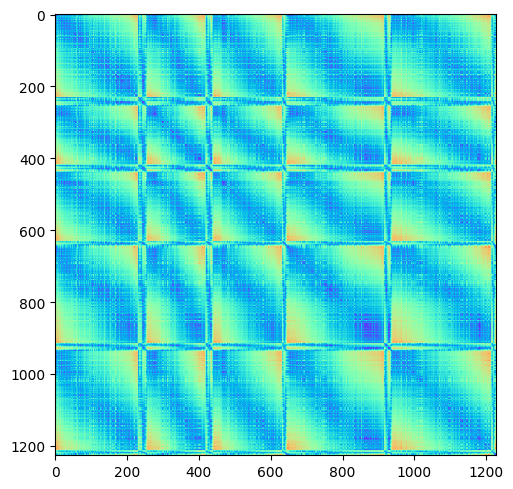

In [292]:
#dd=dist_mv1.argsort(axis=1)

plt.figure(figsize=(10,5),dpi= 100)
plt.imshow(dist_mv,cmap='rainbow')
    

In [293]:
data_CM.shape

(20278, 37)

In [294]:
distance_neigh_CM.shape

(20278, 20)

In [295]:
### save the matrices
df_data = pd.DataFrame(data_CM)
df_data.to_csv(os.path.join(data_path_output + 'cluster/'+'all_matrix.csv'), header=None, index=None)

df_data = pd.DataFrame(distance_neigh_CM)
df_data.to_csv(os.path.join(data_path_output + 'cluster/'+'all_matrix_distance.csv'), header=None, index=None)

'''
df_data = pd.DataFrame(np.array(muta_data_all))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'muta_matrix.csv'), header=None, index=None)


df_data = pd.DataFrame(np.array(pheno_data_all))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'pheno_matrix.csv'), header=None, index=None)


#df_data = pd.DataFrame(np.array(image_id_list))
#df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'image_id_list.csv'), header=None, index=None)

'''
df_data = pd.DataFrame(np.array(fname_list))
df_data.to_csv(os.path.join(data_path_output + 'cluster/'+'file_names_list.csv'), header=None, index=None)


In [296]:
data_path_output

'/Users/4470526/Downloads/Projects/GBM_SCRIPPS/ImageAnalysis_Moffitt_Complete/output/sc2/'

In [297]:
#remove the first row, as this was set to all zeros
data_CM = np.delete(data_CM, (0), axis=0)
distance_neigh_CM = np.delete(distance_neigh_CM, (0), axis=0)

#remove rows that have 0 rowsum

row_sums_CM = data_CM[:,15:35].sum(axis=1,keepdims=True)
rows_remove = np.where(row_sums_CM==0)
data_CM = np.delete(data_CM,(rows_remove),axis=0)
distance_neigh_CM = np.delete(distance_neigh_CM, (rows_remove),axis=0)

In [298]:
matrix_all = data_CM
matrix_all.shape

(20277, 37)

##### 1. Clustering all the cell segment data

In [299]:
#cluster based on phenograph

communities, graph, Q = pg.cluster(matrix_all[:,15:35])#, k =100)#, min_cluster_size=1)#,k=500)
cluster_asgn_all = communities

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.559079885482788 seconds
Jaccard graph constructed in 1.7118439674377441 seconds
Wrote graph to binary file in 2.43786883354187 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.698881
Louvain completed 21 runs in 4.2038893699646 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 11.193940877914429 seconds


In [300]:
#tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=250)
X_2d_all= TSNE().fit(matrix_all[:,15:35])

unique [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]


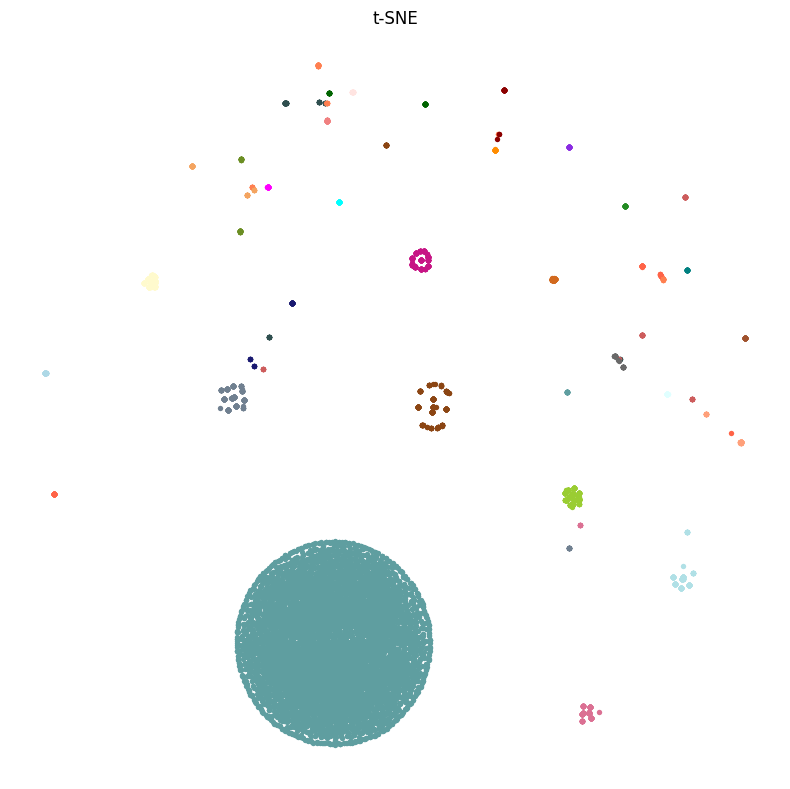

In [301]:
unique, counts = np.unique(cluster_asgn_all, return_counts=True)
print('unique',str(unique))

#t-SNE plots
target_ids = range(len(unique))
plt.figure(figsize=(8,8),frameon=False,dpi=100)
plt.axis('off')
#colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i,  label in zip(target_ids,  unique):
    #print(label)
    c=colours_41[i]
    plt.scatter(X_2d_all[ cluster_asgn_all==(i), 0], X_2d_all[ cluster_asgn_all==(i), 1], color=c,label=label,s=15,linewidths=0)
#plt.legend()
plt.title('t-SNE')
#plt.show()
file_name = os.path.join(data_path_output + '/figures/'+'cluster_all.png')
plt.savefig(file_name,dpi=150)

In [302]:
scaled_X = zscore(matrix_all[:,15:35],axis=1)
y_marker = [geno_labels,pheno_labels,mut_labels]
flat_list = [item for sl in y_marker for item in sl]
print(flat_list)
y_marker=flat_list

['No amp', 'PDGFRA amp', 'EGFR amp', 'CDK4 amp', 'PDGFRA + EGFR amp', 'CDK4 + PDGFRA amp', 'CDK4 + EGFR amp', 'CDK4 + EGFR + PDGFRA amp', 'Unclassified TME', 'Hypoxic Unclassified TME', 'Immune', 'Hypoxic Immune', 'Endothelial', 'Hypoxic Endothelial', 'EC Mimicry Tumor Cell', 'Hypoxic EC Mimicry Tumor Cell', 'Tumor Cell', 'Hypoxic Tumor Cell', 'TERT C228T wt', 'TERT C228T mut']


All label spread


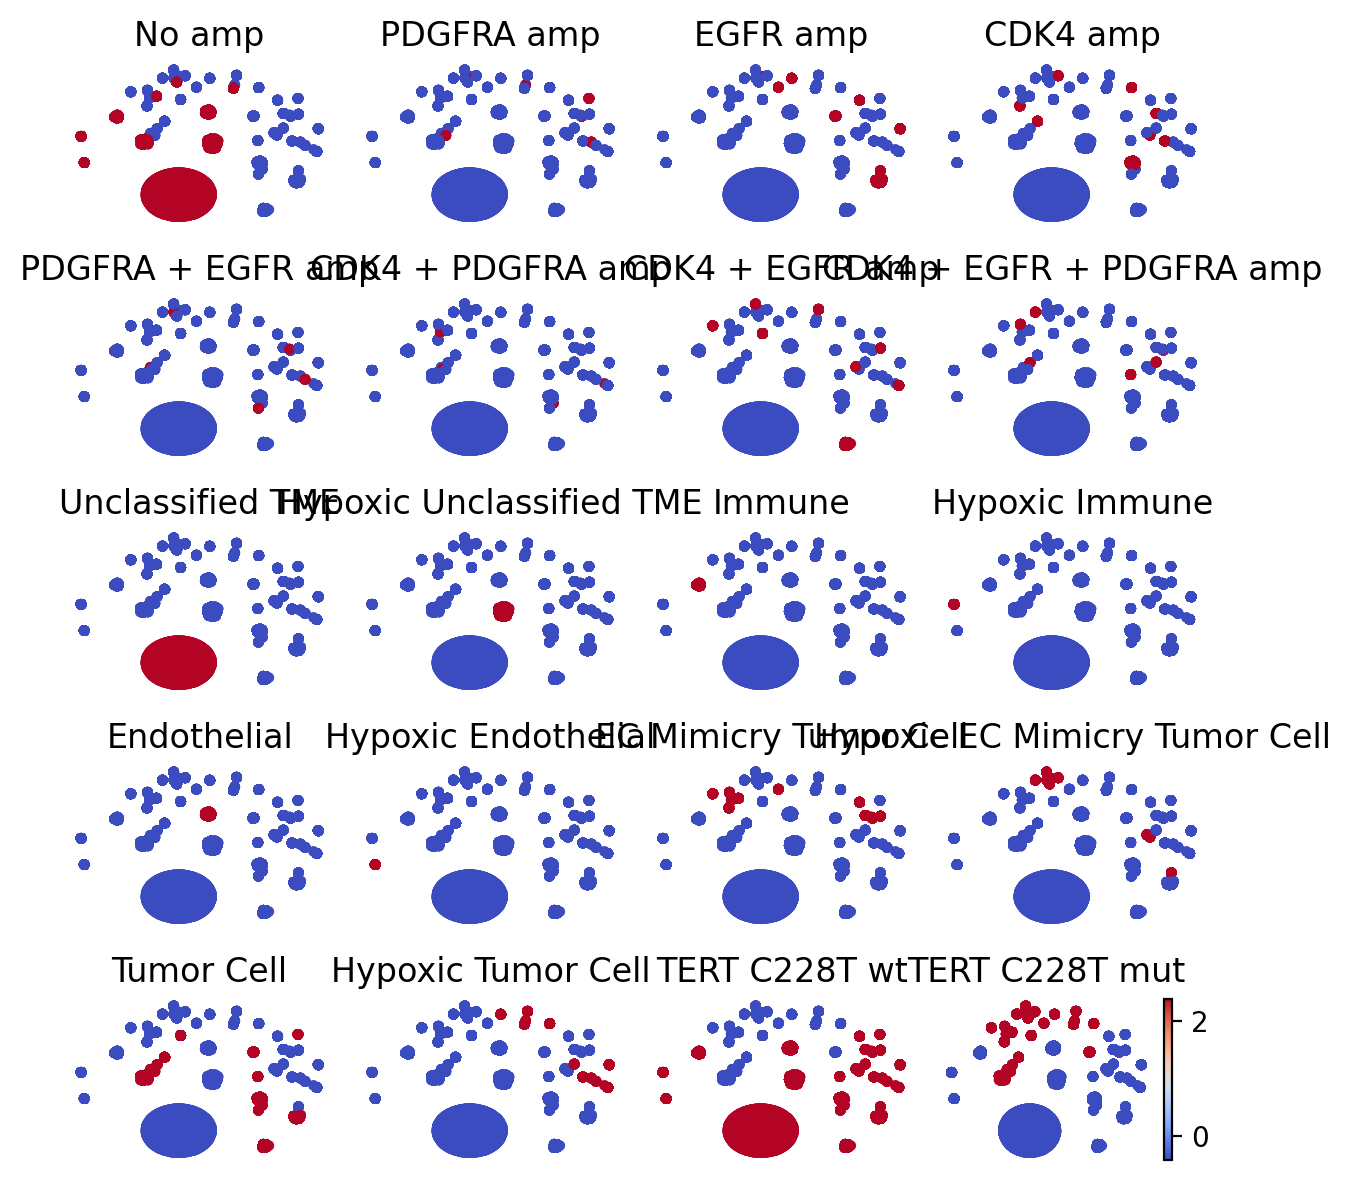

In [303]:


#t-SNE plots
print('All label spread')

#plt.axis('off')

cols = np.int64(len(y_marker)/5)

fig = plt.figure(100, figsize=(6,6),dpi=200)
cc = 0
for m in range(len(y_marker)):
    #print(m)
    #if (m < len(y_marker)):
    ax1 = fig.add_subplot(5,cols,m+1)
    plt.scatter(X_2d_all[:,0], X_2d_all[:,1], c=scaled_X[:,m],   s=15,linewidths=0, cmap='coolwarm')
    plt.axis('off')
    plt.title(y_marker[m])
plt.colorbar()

file_name = os.path.join(data_path_output + '/figures/'+'all_label_distribution.png')
plt.savefig(file_name,dpi=150)



In [304]:
df_data = pd.DataFrame(np.array(X_2d_all))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'X2d_all.csv'), header=None, index=None)

df_data = pd.DataFrame(np.array(cluster_asgn_all))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'cluster_asgn_all.csv'), header=None, index=None)


##### 2. Remove 0th cluster and repeat clustering

In [307]:
row_id_0 = np.array(np.where(cluster_asgn_all==(0))).flatten()
#plt.scatter(X_2d_ss[ data_CM_spat_ss[:,8]==(label), 0], X_2d_ss[ data_CM_spat_ss[:,8]==(label), 1], color=c,label=label,s=1,linewidths=0,alpha=0.9)
print(row_id_0.shape)

(10711,)


In [308]:
matrix_all_redu = np.delete(matrix_all,(row_id_0),axis=0)
print(matrix_all_redu.shape)

(9566, 37)


In [309]:
matrix_all_distance_redu = np.delete(distance_neigh_CM,(row_id_0),axis=0)
print(matrix_all_distance_redu.shape)

(9566, 20)


In [310]:
matrix_all_redu_ = matrix_all_redu[:,15:35]

In [311]:
matrix_all_redu_.shape

(9566, 20)

In [313]:
#phenograph clusters
communities, graph, Q = pg.cluster(matrix_all_redu_, k =100)#, min_cluster_size=1)#,k=500)
cluster_asgn_all_redu = communities

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.7967178821563721 seconds
Jaccard graph constructed in 4.845937728881836 seconds
Wrote graph to binary file in 3.5739309787750244 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.910465
Louvain completed 21 runs in 3.818653106689453 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 13.35988187789917 seconds


In [314]:
cluster_asgn_all_redu.shape

(9566,)

In [315]:
M = matrix_all_redu_

num_cells = M.shape[0]
num_genes = M.shape[1]



In [312]:
### a little trick to handle cells colocalizing at the exact same point (since their features are same or very similar): 
### just add a small random noise to their features in the original matrix,
### and then perform tSNE on this. Note: clustering is performed on the original matrix
eps_val = 0.0001
mock_mat = np.random.randint(2, size=(matrix_all_redu_.shape[0], matrix_all_redu_.shape[1])) * eps_val

In [316]:
#tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=250)
X_2d_all_redu = TSNE().fit(M*mock_mat)


unique [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
counts [1604 1052  861  842  791  788  585  485  389  310  243  224  218  171
  169  169  124  110  109  108   90   68   56]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


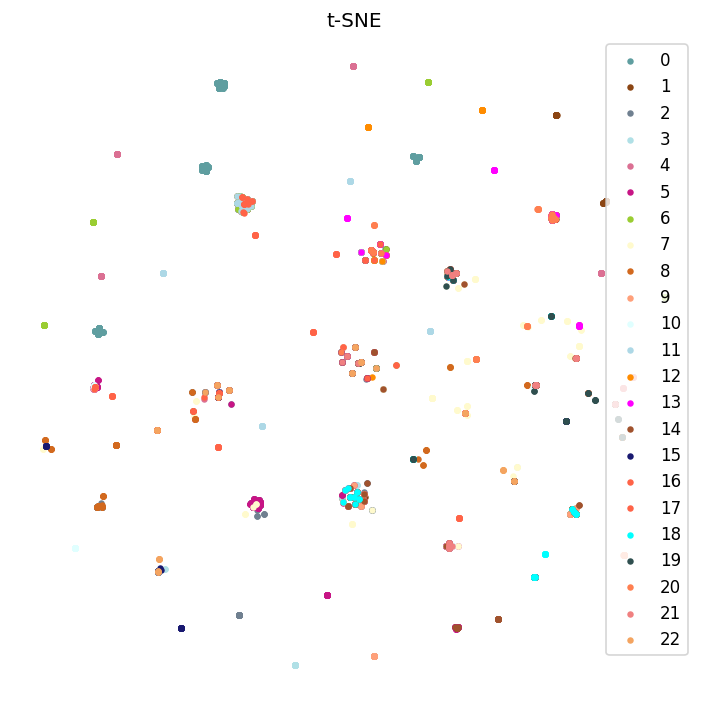

In [319]:
unique, counts = np.unique(cluster_asgn_all_redu, return_counts=True)
print('unique',str(unique))
print('counts',str(counts))
#
#t-SNE plots
target_ids = range(len(unique))
plt.figure(figsize=(6,6),frameon=False,dpi=120)
plt.axis('off')

for i,  label in zip(target_ids,  unique):
    print(label)
    c=colours_41[i]
    plt.scatter(X_2d_all_redu[ cluster_asgn_all_redu==(i), 0], X_2d_all_redu[ cluster_asgn_all_redu==(i), 1], color=c,label=label,s=15,linewidths=0)
plt.legend()
plt.title('t-SNE')
#plt.show()
file_name = os.path.join(data_path_output + '/figures/'+'cluster_all_reduced.png')
plt.savefig(file_name,dpi=150)

In [320]:
scaled_X = zscore(matrix_all_redu_,axis=1)
y_marker=flat_list

All label spread


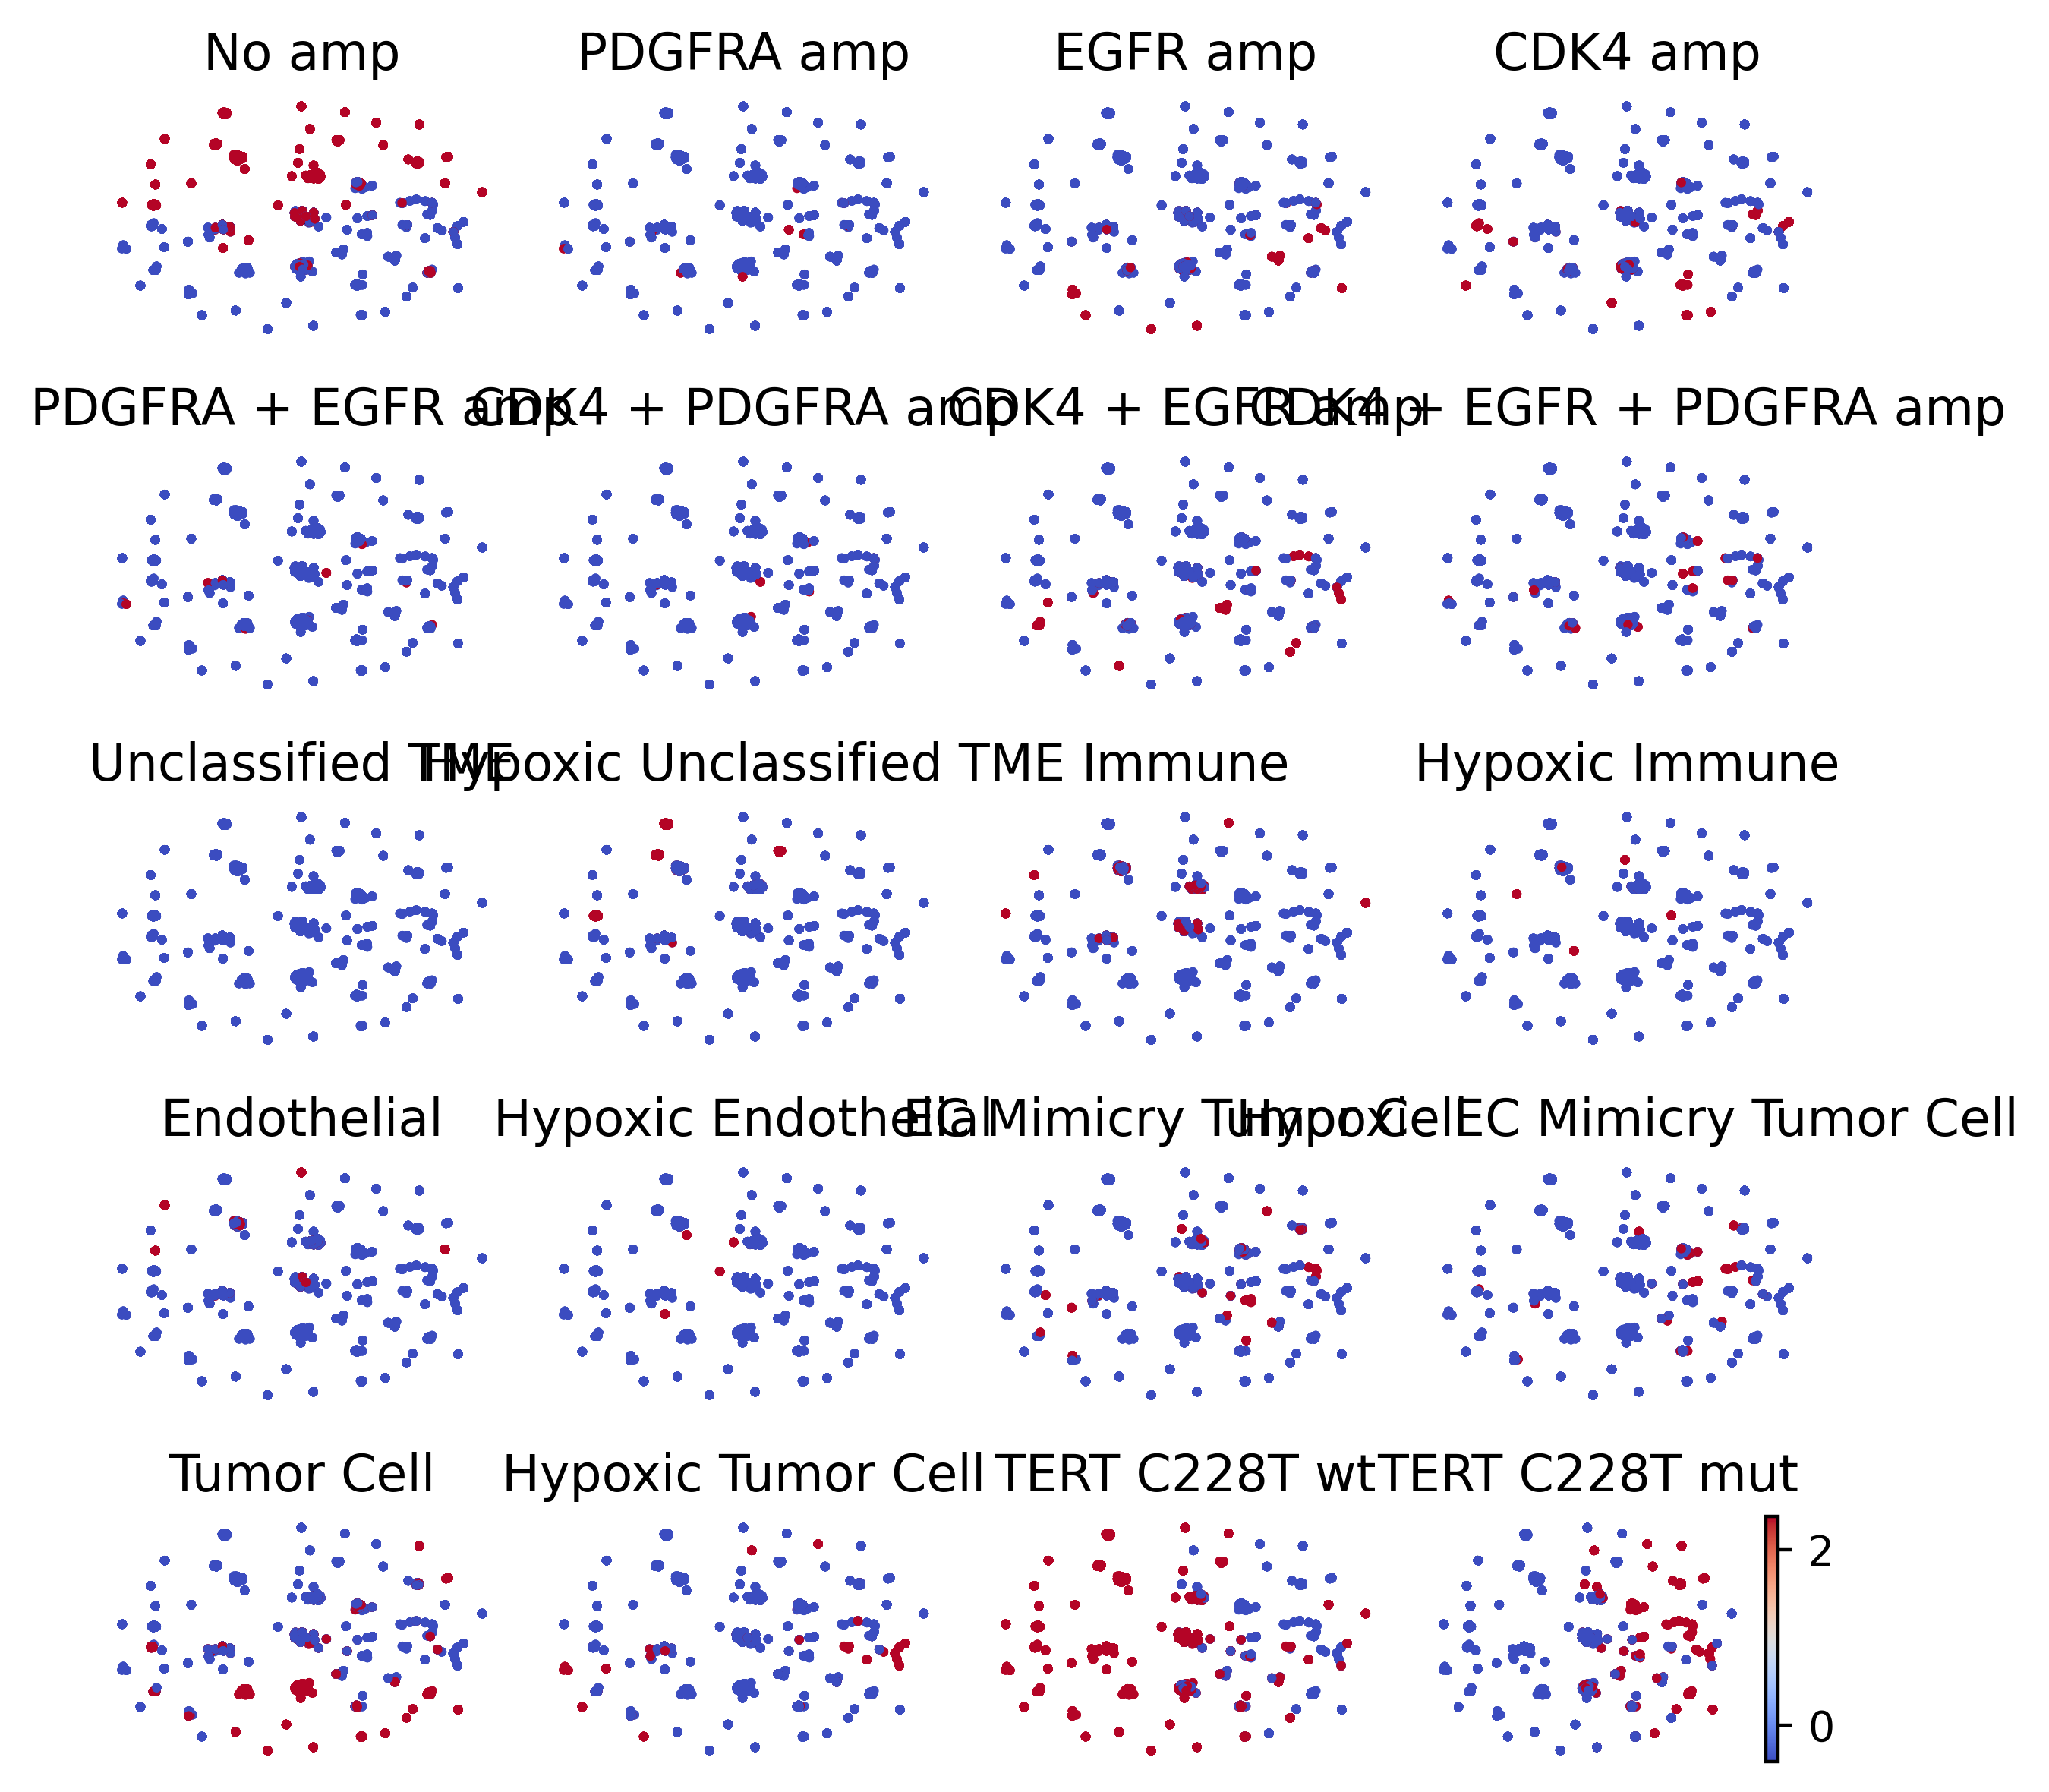

In [321]:


#t-SNE plots
print('All label spread')
#plt.figure(100, figsize=(6,6),dpi=400)
#plt.axis('off')

cols = np.int64(len(y_marker)/5)

fig = plt.figure(100, figsize=(6,6),dpi=400)
cc = 0
for m in range(len(y_marker)):
    #print(m)
    #if (m < len(y_marker)):
    ax1 = fig.add_subplot(5,cols,m+1)
    plt.scatter(X_2d_all_redu[:,0], X_2d_all_redu[:,1], c=scaled_X[:,m],   s=5,linewidths=0, cmap='coolwarm')
    plt.axis('off')
    plt.title(y_marker[m])
plt.colorbar()

file_name = os.path.join(data_path_output + '/figures/'+'all_label_distribution_reduced.png')
plt.savefig(file_name,dpi=150)



In [322]:
df_data = pd.DataFrame(np.array(matrix_all))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'matrix_all.csv'), header=None, index=None)

df_data = pd.DataFrame(np.array(matrix_all_distance_redu))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'matrix_all_distance_reduced.csv'), header=None, index=None)


df_data = pd.DataFrame(np.array(matrix_all_redu))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'matrix_all_reduced.csv'), header=None, index=None)

df_data = pd.DataFrame(np.array(X_2d_all_redu))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'X2d_all_reduced.csv'), header=None, index=None)

df_data = pd.DataFrame(np.array(cluster_asgn_all_redu))
df_data.to_csv(os.path.join(data_path_output + '/cluster/'+'cluster_asgn_all_reduced.csv'), header=None, index=None)


In [174]:
### 
'''scanpy!!tried but was not flexible
'''

'scanpy!!\n'

In [175]:
'''
matrix_all_redu = np.array(matrix_all_redu, dtype=np.int32)
type(matrix_all_redu)
matrix_all_redu.shape
'''

(9566, 37)

In [72]:
#import scanpy as sc

In [81]:
#adata = sc.AnnData(matrix_all_redu)

In [82]:
#adata

AnnData object with n_obs × n_vars = 9565 × 20

In [83]:
'''
ct = cluster_asgn_all_redu#np.array(response_data).flatten()#, ndmin=(sc_adata.n_obs))
adata.obs["leiden"] = pd.Categorical(ct)  # Categoricals are preferred for efficiency
adata.obs
'''

,leiden
0,6
1,11
2,9
3,0
4,3
...,...
9560,14
9561,6
9562,4
9563,6


/opt/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:546: RuntimeWarning: divide by zero encountered in log
  scores = np.log(scores)


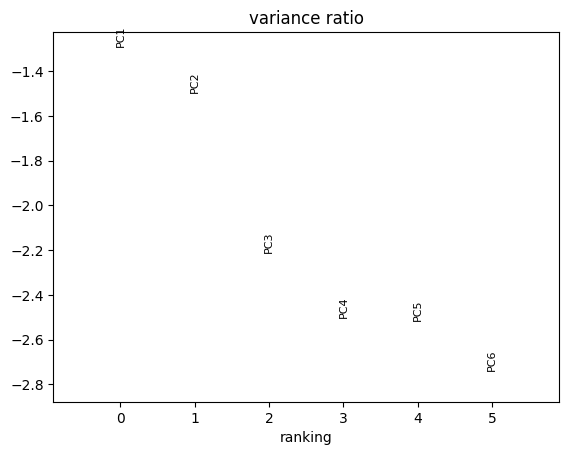

In [84]:
#sc.tl.pca(adata, svd_solver='arpack')
#sc.pl.pca_variance_ratio(adata, log=True, n_pcs=5, save='') # scanpy generates the filename automatically

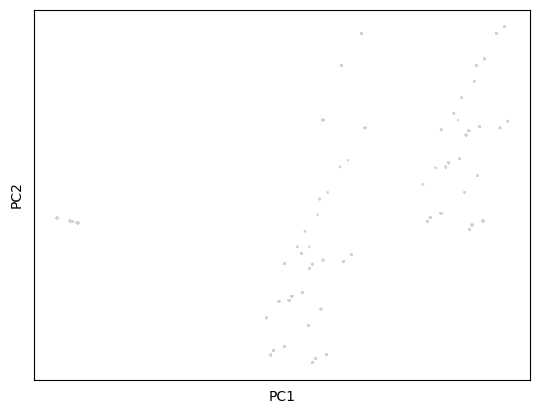

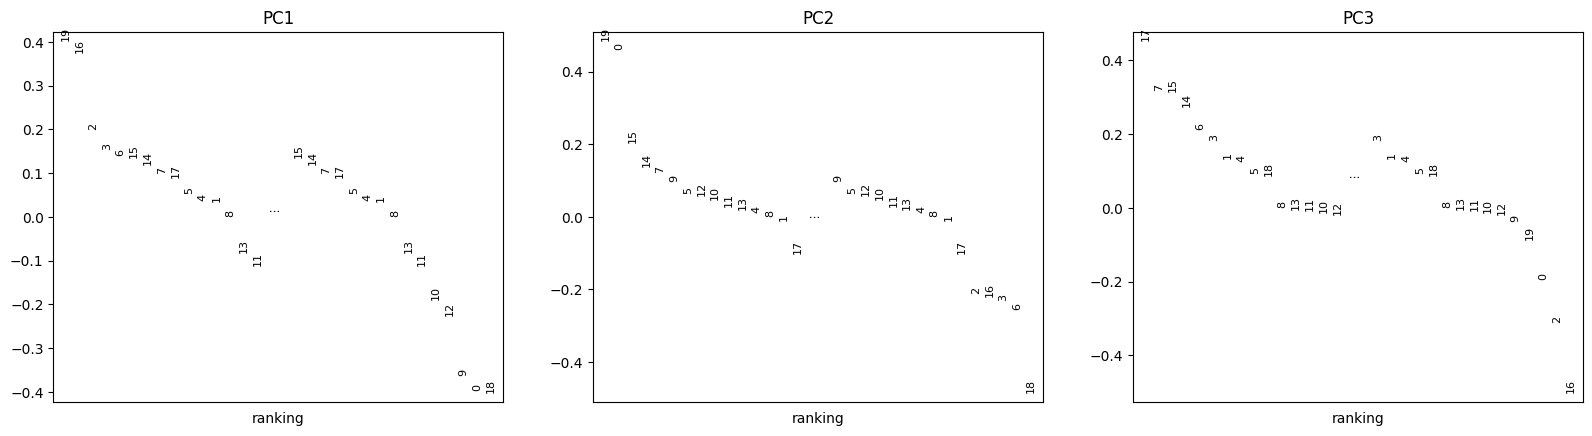

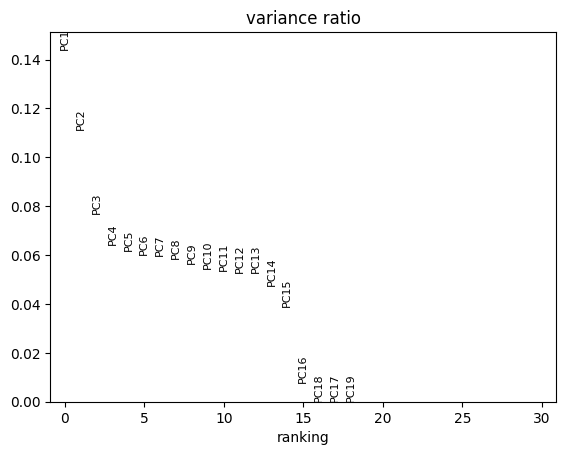

In [85]:
'''
sc.pp.log1p(adata)  # Returns or updates data, depending on copy. X = log(X + 1) 
sc.pp.scale(adata)  # Scale data to unit variance and zero mean.
# updates adata with a scaled adata.X, annotated with 'mean' and 'std' in adata.var.
sc.pp.pca(adata)  
sc.pl.pca_overview(adata)#, color='plate.barcode')
'''

In [ ]:
#########sc.pp.neighbors(adata)#, n_neighbors=10, n_pcs=3)
#sc.tl.umap(adata)
#sc.tl.leiden(adata, resolution=0.5)
#sc.pl.umap(adata, color=['leiden'], legend_fontsize=8, save='_leiden')

##### 3. Multiview clustering by pooling all the cell segments 

In [323]:
gbm_mv_list = []
gbm_mv_list.append(matrix_all_redu_) 
gbm_mv_list.append(matrix_all_distance_redu) 

In [324]:
matrix_all_distance_redu.shape

(9566, 20)

In [325]:
m_spectral2 = MultiviewCoRegSpectralClustering(n_clusters=20,
                                               random_state=10,
                                               n_init=10)
m_clusters2 = m_spectral2.fit_predict(gbm_mv_list)

In [326]:
#m_cluster21 = m_clusters2 #10 clusters

In [327]:
len(colours_41)

64

unique [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
counts [ 791 1052 1604  766  829  809  585  262  341  273  220  280  224  227
  310  273  153  276  167  124]


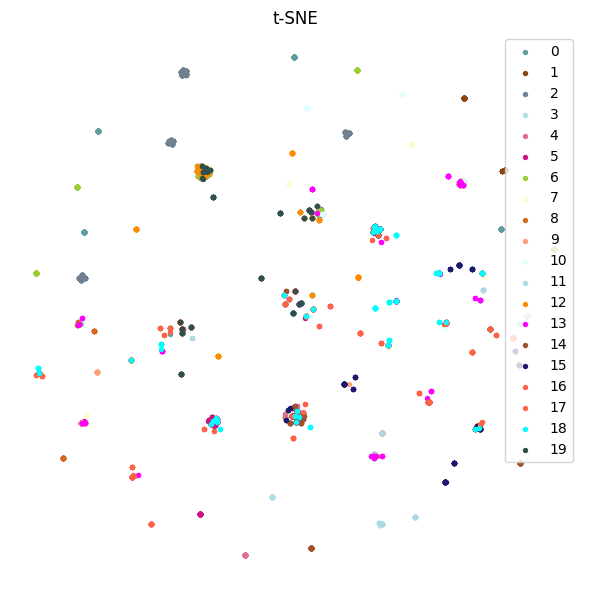

In [336]:
##note that the 2d representation is from count data alone, not using distances

unique, counts = np.unique(m_clusters2, return_counts=True)
print('unique',str(unique))
print('counts',str(counts))
#
#t-SNE plots
target_ids = range(len(unique))
plt.figure(figsize=(6,6),frameon=False,dpi=100)
plt.axis('off')

for i,  label in zip(target_ids,  unique):
    #print(label)
    c=colours_41[i]
    plt.scatter(X_2d_all_redu[ m_clusters2==(i), 0], X_2d_all_redu[ m_clusters2==(i), 1], color=c,label=label,s=15,linewidths=0)
plt.legend()
plt.title('t-SNE')
#plt.show()
file_name = os.path.join(data_path_output + '/figures/'+'cluster_all_reduced.png')
plt.savefig(file_name,dpi=150)

In [337]:
print('Postprocessing the Count matrix results')
####post processing

## plot heatmaps and clustermaps

cluster_stats = np.zeros([len(target_ids),20], dtype=float)
yticks = np.array(target_ids)
for k in target_ids:
    #print(k)
    yticks[k] = int(k)
    cell_rows = np.array(np.where(m_clusters2 == (k))).flatten()
    cluster_stats[k,:] = matrix_all_redu_[cell_rows,:].sum(axis=0,keepdims=True)
    
    
cluster_stats[np.isnan(cluster_stats)] = 0

Postprocessing the Count matrix results


<Figure size 1600x1600 with 0 Axes>

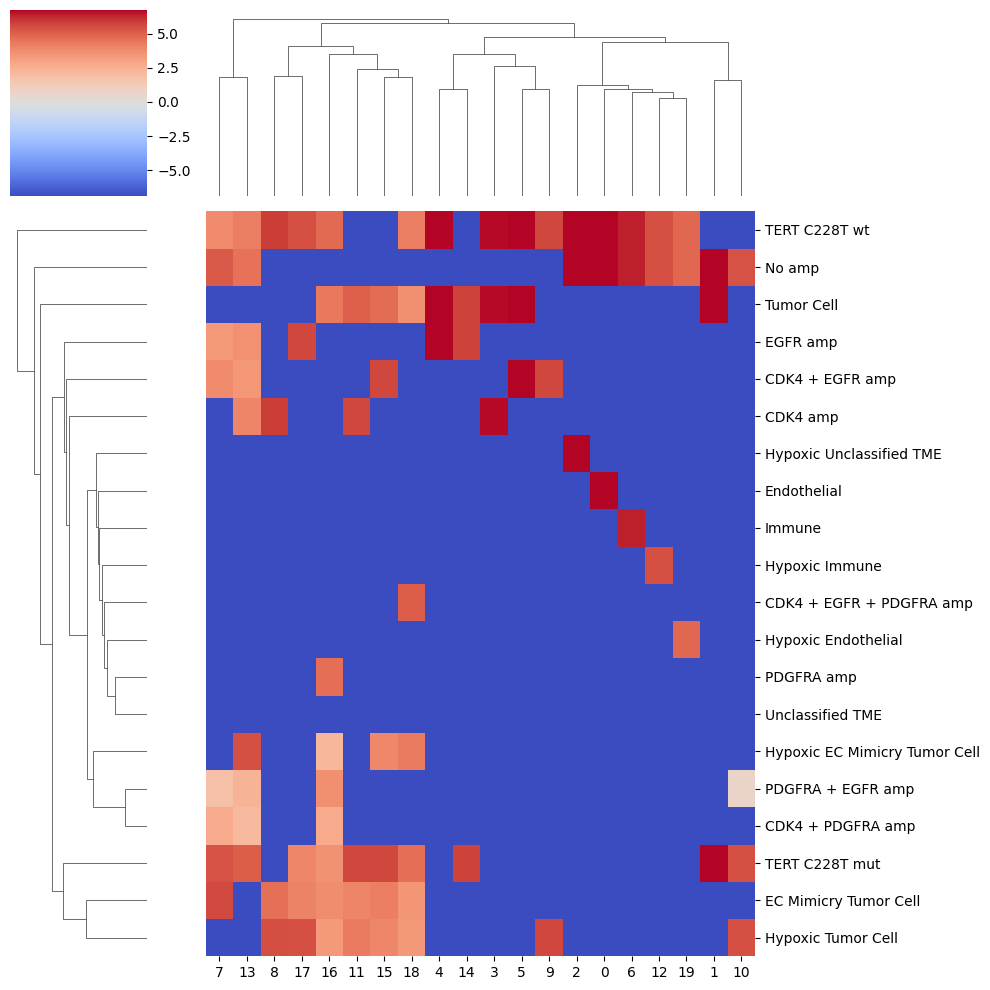

In [353]:
plt.figure(3000 ,dpi=200,figsize=(8,8))
hm= sns.clustermap(np.transpose(np.log(cluster_stats+0.001)),cmap='coolwarm',robust='True',xticklabels=yticks,yticklabels=y_marker)

#file_name = os.path.join(path_fig+categ+'/clustermap_spat_scaled_look_'+categ+'.png')
#file_name = os.path.join(path_c+'/Clustermap_zscored.png')
#plt.savefig(file_name,dpi='figure')
#plt.close()


In [339]:
matrix_all_redu.shape

(9566, 37)

unique [0. 1.]
unique [1. 2. 3. 4. 5. 6. 7. 8. 9.]
0
1
2
3
4
5
6
7
8


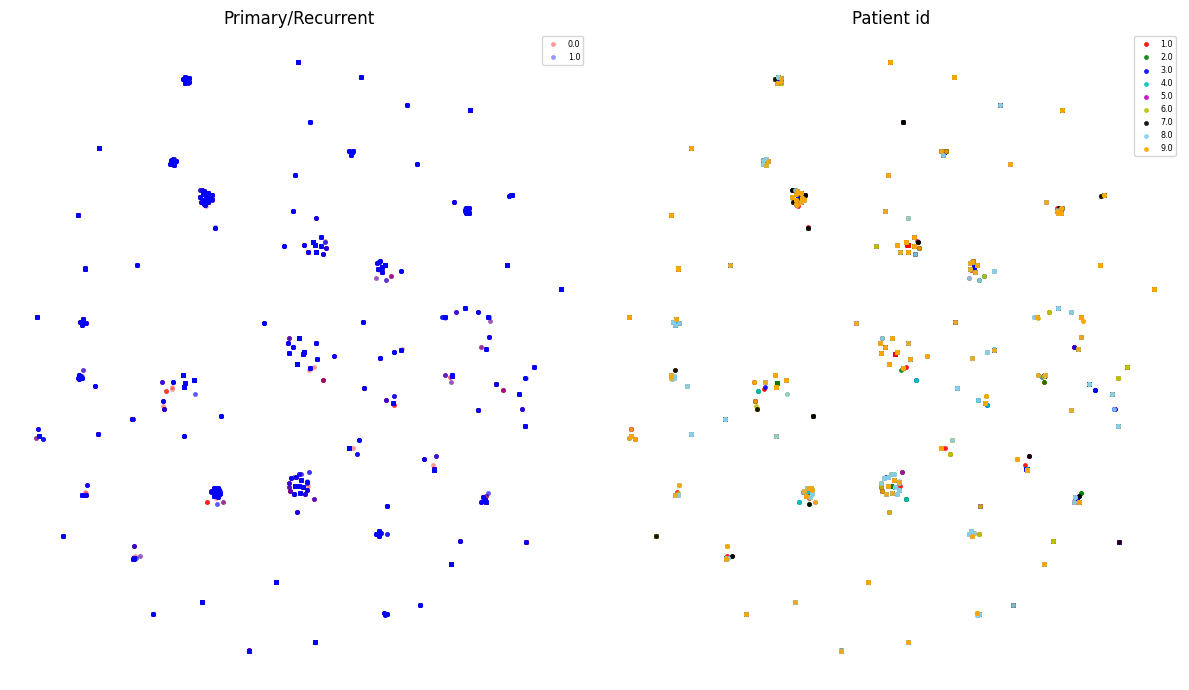

In [340]:
plt.rcParams["figure.figsize"] = [12,7]
plt.rcParams["figure.autolayout"] = True


## response data
plt.subplot(1,2,1)
unique, counts = np.unique(matrix_all_redu[:,35]  , return_counts=True)
print('unique',str(unique))
#cm = plt.cm.get_cmap('tab20c', len(unique))
#t-SNE plots
target_ids = range(len(unique))
#plt.figure(300, figsize=(5,6),frameon=False,dpi=100)
plt.axis('off')
colors = ['red', 'blue']
for i,  label in zip(target_ids,  unique):
    #print(label)
    s=np.array(np.where(matrix_all_redu[:,35] ==i)).flatten()
    #print(s)
    plt.scatter(X_2d_all_redu[ s, 0],X_2d_all_redu[ s, 1], color=colors[i],label=label,s=12,linewidths=0,alpha=0.4)
plt.legend(fontsize='xx-small')
plt.title('Primary/Recurrent')


                     
## patient id data
plt.subplot(1,2,2)
unique, counts = np.unique(matrix_all_redu[:,36] , return_counts=True)

print('unique',str(unique))
#cm = plt.cm.get_cmap('tab20c', len(unique))
#t-SNE plots
target_ids = range(len(unique))
#plt.figure(300, figsize=(5,6),frameon=False,dpi=100)
plt.axis('off')
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'skyblue', 'orange', 'purple']
for i,  label in zip(target_ids,  unique):
    #print(label)
    print(i)
    s=np.array(np.where(matrix_all_redu[:,36]==label)).flatten()
    #print(s)
    plt.scatter(X_2d_all_redu[ s, 0],X_2d_all_redu[ s, 1], color=colors[i],label=label,s=12,linewidths=0,alpha=0.9)
plt.legend(fontsize='xx-small')
plt.title('Patient id')

file_name = os.path.join(data_path_output + '/figures/'+'mv_cluster_pat_resp.png')
#plt.savefig(file_name,dpi=150)


##### 4. MV clustering for primary / recurrent subgroups

In [341]:
## collecting the rows corresponding to primary and recurrent

# primary = 0
#recurrent = 1
row_resp = []

unique_r, counts_r = np.unique(matrix_all_redu[:,35]  , return_counts=True)
target_ids_r = range(len(unique_r))
for i,  label in zip(target_ids_r,  unique_r):
    print(label)
    s=np.array(np.where(matrix_all_redu[:,35] ==i)).flatten()
    row_resp.append(s)

0.0
1.0


###### Primary

In [342]:
## primary
gbm_mv_list_p = []
gbm_mv_list_p.append(matrix_all_redu_[row_resp[0],:]) 
gbm_mv_list_p.append(matrix_all_distance_redu[row_resp[0],:]) 

In [343]:
m_spectral2_p = MultiviewCoRegSpectralClustering(n_clusters=20,
                                               random_state=10,
                                               n_init=10)
m_clusters2_p = m_spectral2_p.fit_predict(gbm_mv_list_p)

In [354]:
eps_val = 0.0001
mock_mat = np.random.randint(2, size=(row_resp[0].shape[0], matrix_all_redu_.shape[1])) * eps_val
X_2d_all_redu_p = TSNE().fit(matrix_all_redu_[row_resp[0],:]*mock_mat)

unique [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
counts [480 466 633 562 424 296  98 262 131 149 207 110 105  99 104  61  67 110
  98  63]


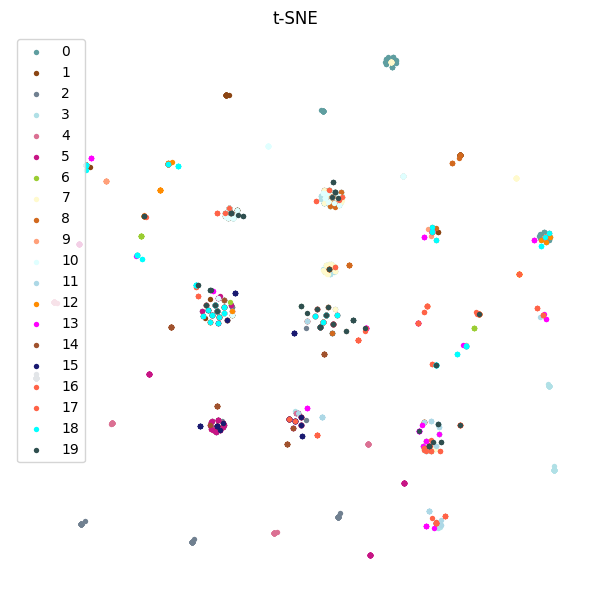

In [355]:
##note that the 2d representation is from count data alone, not using distances

unique, counts = np.unique(m_clusters2_p, return_counts=True)
print('unique',str(unique))
print('counts',str(counts))
#
#t-SNE plots
target_ids = range(len(unique))
plt.figure(figsize=(6,6),frameon=False,dpi=100)
plt.axis('off')

for i,  label in zip(target_ids,  unique):
    #print(label)
    c=colours_41[i]
    plt.scatter(X_2d_all_redu_p[ m_clusters2_p==(i), 0], X_2d_all_redu_p[ m_clusters2_p==(i), 1], color=c,label=label,s=15,linewidths=0)
plt.legend()
plt.title('t-SNE')
#plt.show()
file_name = os.path.join(data_path_output + '/figures/'+'cluster_all_reduced_p.png')
plt.savefig(file_name,dpi=150)

In [356]:
print('Postprocessing the Count matrix results')
####post processing

## plot heatmaps and clustermaps
m_p = matrix_all_redu_[row_resp[0],:]

cluster_stats_p = np.zeros([len(target_ids),20], dtype=float)
yticks = np.array(target_ids)
for k in target_ids:
    #print(k)
    yticks[k] = int(k)
    cell_rows = np.array(np.where(m_clusters2_p == (k))).flatten()
    cluster_stats_p[k,:] = m_p[cell_rows,:].sum(axis=0,keepdims=True)
    
    
cluster_stats_p[np.isnan(cluster_stats_p)] = 0

Postprocessing the Count matrix results


<Figure size 1600x1600 with 0 Axes>

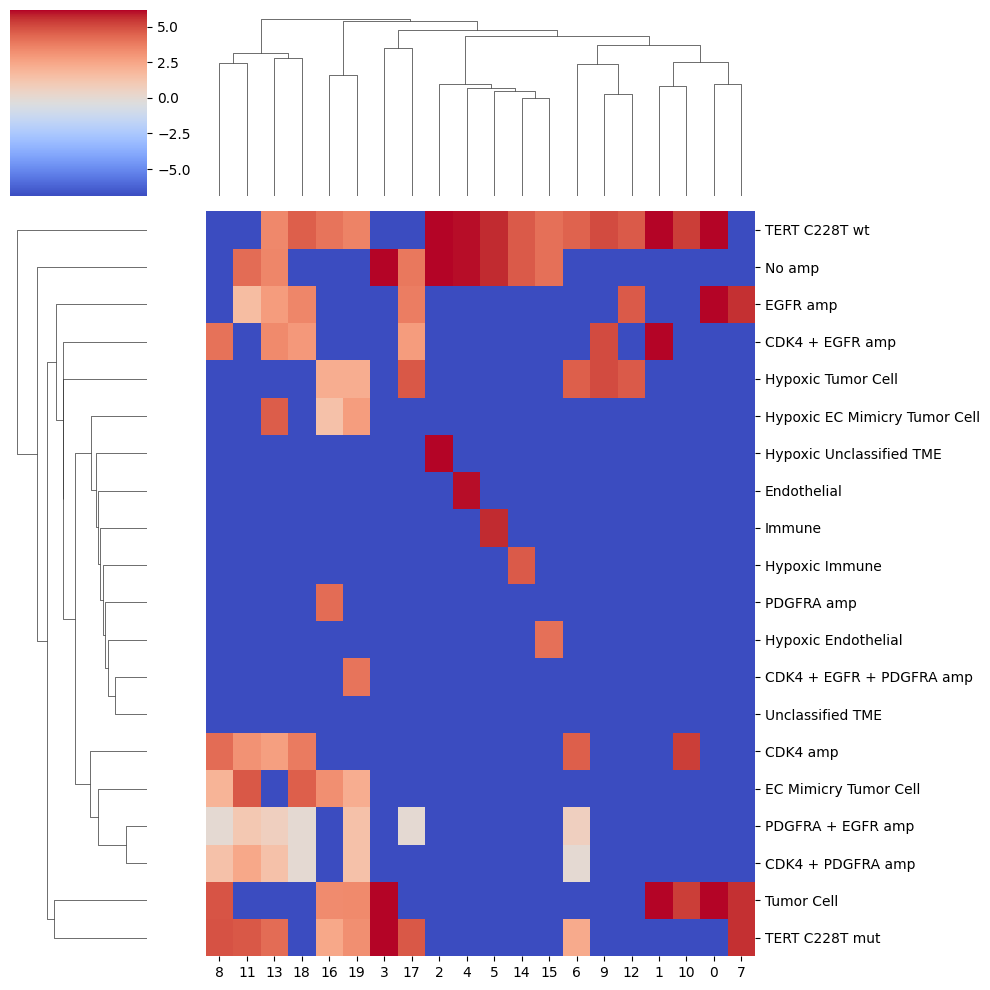

In [357]:
plt.figure(3000 ,dpi=200,figsize=(8,8))
hm= sns.clustermap(np.transpose(np.log(cluster_stats_p+0.001)),cmap='coolwarm',robust='True',xticklabels=yticks,yticklabels=y_marker)

#file_name = os.path.join(path_fig+categ+'/clustermap_spat_scaled_look_'+categ+'.png')
#file_name = os.path.join(path_c+'/Clustermap_zscored.png')
#plt.savefig(file_name,dpi='figure')
#plt.close()


###### Recurrent

In [359]:
## recurrent
gbm_mv_list_r = []
gbm_mv_list_r.append(matrix_all_redu_[row_resp[1],:]) 
gbm_mv_list_r.append(matrix_all_distance_redu[row_resp[1],:]) 

In [360]:
m_spectral2_r = MultiviewCoRegSpectralClustering(n_clusters=20,
                                               random_state=10,
                                               n_init=10)
m_clusters2_r = m_spectral2_r.fit_predict(gbm_mv_list_r)

In [361]:
eps_val = 0.0001
mock_mat = np.random.randint(2, size=(row_resp[1].shape[0], matrix_all_redu_.shape[1])) * eps_val
X_2d_all_redu_r = TSNE().fit(matrix_all_redu_[row_resp[1],:]*mock_mat)

unique [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
counts [156 367 971 559 349 343 490 289 168 119 120 180 158 107 107 124 112 184
  63  75]


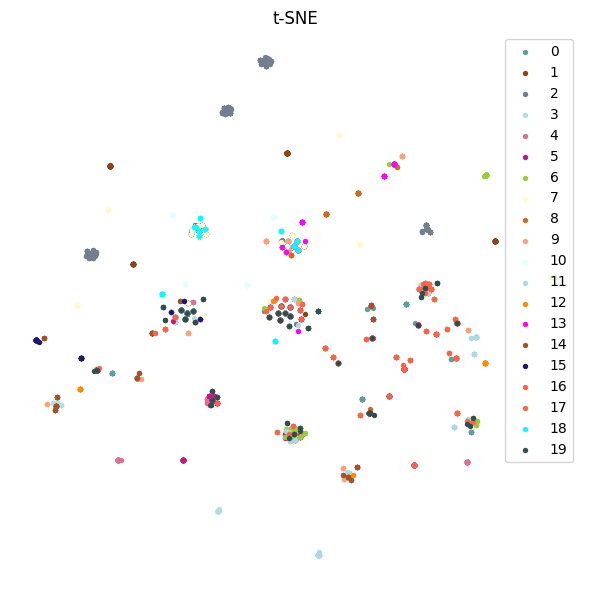

In [362]:
##note that the 2d representation is from count data alone, not using distances

unique, counts = np.unique(m_clusters2_r, return_counts=True)
print('unique',str(unique))
print('counts',str(counts))
#
#t-SNE plots
target_ids = range(len(unique))
plt.figure(figsize=(6,6),frameon=False,dpi=100)
plt.axis('off')

for i,  label in zip(target_ids,  unique):
    #print(label)
    c=colours_41[i]
    plt.scatter(X_2d_all_redu_r[ m_clusters2_r==(i), 0], X_2d_all_redu_r[ m_clusters2_r==(i), 1], color=c,label=label,s=15,linewidths=0)
plt.legend()
plt.title('t-SNE')
#plt.show()
file_name = os.path.join(data_path_output + '/figures/'+'cluster_all_reduced_r.png')
plt.savefig(file_name,dpi=150)

In [363]:
print('Postprocessing the Count matrix results')
####post processing

## plot heatmaps and clustermaps
m_r = matrix_all_redu_[row_resp[1],:]

cluster_stats_r = np.zeros([len(target_ids),20], dtype=float)
yticks = np.array(target_ids)
for k in target_ids:
    #print(k)
    yticks[k] = int(k)
    cell_rows = np.array(np.where(m_clusters2_r == (k))).flatten()
    cluster_stats_r[k,:] = m_r[cell_rows,:].sum(axis=0,keepdims=True)
    
    
cluster_stats_r[np.isnan(cluster_stats_r)] = 0

Postprocessing the Count matrix results


<Figure size 1600x1600 with 0 Axes>

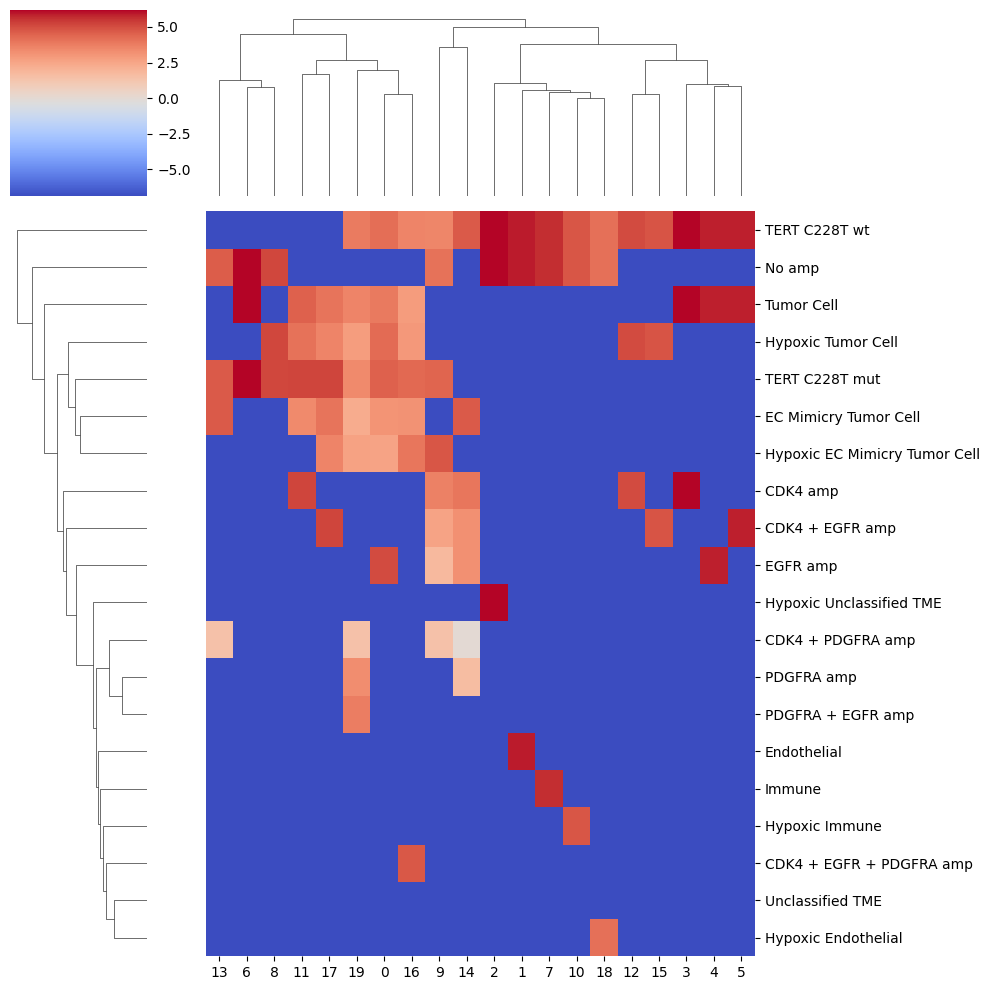

In [364]:
plt.figure(3000 ,dpi=200,figsize=(8,8))
hm= sns.clustermap(np.transpose(np.log(cluster_stats_r+0.001)),cmap='coolwarm',robust='True',xticklabels=yticks,yticklabels=y_marker)

#file_name = os.path.join(path_fig+categ+'/clustermap_spat_scaled_look_'+categ+'.png')
#file_name = os.path.join(path_c+'/Clustermap_zscored.png')
#plt.savefig(file_name,dpi='figure')
#plt.close()
